<a href="https://colab.research.google.com/github/youuRee/DeepLearning_Lecture/blob/main/Part5/05_CNN_Simple_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN Code Example 1


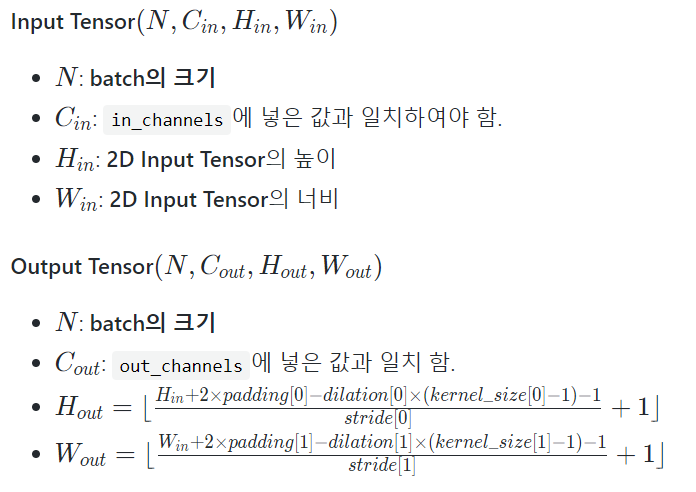

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5, stride=1)
    self.fc1 = nn.Linear(9 * 12 * 12, 50) # (input_dim, output_dim)
    self.fc2 = nn.Linear(50, 10)
  
  def forward(self, x):
    print("연산 전", x.size())
    x = F.relu(self.conv1(x))
    print("conv1 연산 후", x.size())
    x = F.relu(self.conv2(x))
    print("conv2 연산 후",x.size())
    x = x.view(-1, 9 * 12 * 12) # dim 감소(flatten)
    print("차원 감소 후", x.size())
    x = F.relu(self.fc1(x))
    print("fc1 연산 후", x.size())
    x = self.fc2(x)
    print("fc2 연산 후", x.size())
    return x

cnn = CNN()
output = cnn(torch.randn(10, 1, 20, 20))
    

연산 전 torch.Size([10, 1, 20, 20])
conv1 연산 후 torch.Size([10, 3, 16, 16])
conv2 연산 후 torch.Size([10, 9, 12, 12])
차원 감소 후 torch.Size([10, 1296])
fc1 연산 후 torch.Size([10, 50])
fc2 연산 후 torch.Size([10, 10])


## CNN Code Example 2

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.max_pool1 = nn.MaxPool2d(kernel_size=2)
    self.max_pool2 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(10 * 5 * 5, 50)
    self.fc2 = nn.Linear(50, 10)
  
  def forward(self, x):
    print("연산 전", x.size())
    x = F.relu(self.max_pool1(x))
    print("max_pool1 연산 후", x.size())
    x = F.relu(self.max_pool2(x))
    print("max_pool2 연산 후",x.size())
    x = x.view(-1, 10 * 5 * 5)
    print("차원 감소 후", x.size())
    x = F.relu(self.fc1(x))
    print("fc1 연산 후", x.size())
    x = self.fc2(x)
    print("fc2 연산 후", x.size())
    return x

cnn = CNN()
output = cnn(torch.randn(10, 1, 20, 20))

연산 전 torch.Size([10, 1, 20, 20])
max_pool1 연산 후 torch.Size([10, 1, 10, 10])
max_pool2 연산 후 torch.Size([10, 1, 5, 5])
차원 감소 후 torch.Size([1, 250])
fc1 연산 후 torch.Size([1, 50])
fc2 연산 후 torch.Size([1, 10])


## MNIST 모델 학습


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset

from torchvision.transforms import ToTensor

In [16]:
# datasets : 샘플과 정답(label)을 저장
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# DataLoader : 미니 배치 학습이나 데이터 셔플, 병렬 처리 필요할 때
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=50, shuffle=True)


In [17]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x


In [18]:
cnn = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

# 학습
cnn.train()
for epoch in range(10):
  for idx, (data, target) in enumerate(train_loader): # emumerate : 인덱스와 인자 같이 반환 해줌
    optimizer.zero_grad # gradient 초기화 (pytorch는 미분 값들이 누적됨 -> 0으로 초기화!)
    output = cnn(data)
    loss = criterion(output, target)
    optimizer.step()

    if idx % 100 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, idx, loss.item()))

# 테스트
cnn.eval()
test_loss = 0
correct = 0

with torch.no_grad():
  for data, target in test_loader:
    output = cnn(data)
    test_loss += criterion(output, target).item() # item() : tensor에 저장된 숫자 값 가져옴
    pred = output.argmax(dim=1, keepdim=True) # argmax() : input 텐서 에있는 모든 요소의 최대 값 인덱스를 반환
    # dim=1 -> 1차원으로 keepdim=True -> dim=1 작용
    correct += pred.eq(target.view_as(pred)).sum().item() # eq() : target과 pred 같은지 비교

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


loss of 0 epoch, 0 index : 2.3046064376831055
loss of 0 epoch, 100 index : 2.279674530029297
loss of 0 epoch, 200 index : 2.307262420654297
loss of 0 epoch, 300 index : 2.294229030609131
loss of 0 epoch, 400 index : 2.3198232650756836
loss of 0 epoch, 500 index : 2.312817096710205
loss of 0 epoch, 600 index : 2.3029565811157227
loss of 0 epoch, 700 index : 2.302640914916992
loss of 0 epoch, 800 index : 2.2981679439544678
loss of 0 epoch, 900 index : 2.3018484115600586
loss of 0 epoch, 1000 index : 2.3132786750793457
loss of 0 epoch, 1100 index : 2.2981855869293213
loss of 1 epoch, 0 index : 2.3021581172943115
loss of 1 epoch, 100 index : 2.2978203296661377
loss of 1 epoch, 200 index : 2.303881883621216
loss of 1 epoch, 300 index : 2.2968356609344482
loss of 1 epoch, 400 index : 2.2977521419525146
loss of 1 epoch, 500 index : 2.311953544616699
loss of 1 epoch, 600 index : 2.2836849689483643
loss of 1 epoch, 700 index : 2.300715684890747
loss of 1 epoch, 800 index : 2.2943239212036133
lo